# 🛩️ Análise Completa de Codeshare Gol x Azul com Algoritmo de Johnson

## 📊 Análise de Oportunidades de Codeshare usando Dados Reais do Kaggle

Este notebook implementa uma análise completa das malhas aéreas da **Gol** e **Azul** usando dados reais do Kaggle, aplicando o **Algoritmo de Johnson** para identificar oportunidades de codeshare.

### 🎯 Objetivos:
- Processar dados reais de rotas aéreas do Kaggle
- Construir grafo da rede combinada Gol + Azul
- Aplicar algoritmo de Johnson para caminhos mais curtos
- Identificar oportunidades reais de codeshare
- Visualizar resultados geograficamente

### 📈 Dados Utilizados:
- **Dataset**: Airline Routes 92k and Airports 10k (Kaggle)
- **Companhias**: G3 (Gol) e AD (Azul)
- **Período**: Dados históricos consolidados

## 🔧 1. Setup Inicial - Clonagem e Instalação

In [1]:
# 🚀 Clonar repositório e configurar ambiente
!git clone https://github.com/rglopesdf/airline-network-shortest-paths.git

# Navegar para o diretório
import os
os.chdir('airline-network-shortest-paths')

# Instalar dependências
!pip install -q networkx pandas numpy matplotlib seaborn plotly pyvis ipywidgets folium

print("✅ Repositório clonado e dependências instaladas!")
print("📁 Diretório atual:", os.getcwd())
!ls -la

Cloning into 'airline-network-shortest-paths'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 55 (delta 8), reused 45 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (55/55), 7.40 MiB | 21.30 MiB/s, done.
Resolving deltas: 100% (8/8), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.0 MB/s eta 0:00:00
✅ Repositório clonado e dependências instaladas!
📁 Diretório atual: /content/airline-network-shortest-paths
total 72
drwxr-xr-x 9 root root  4096 Jun 26 04:48 .
drwxr-xr-x 1 root root  4096 Jun 26 04:48 ..
-rw-r--r-- 1 root root  2172 Jun 26 04:48 CONTRIBUTING.md
drwxr-xr-x 5 root root  4096 Jun 26 04:48 data
drwxr-xr-x 2 root root  4096 Jun 26 04:48 docs
drwxr-xr-x 2 root root  4096 Jun 26 04:48 examples
drwxr-xr-x 8 root root  4096 Jun 26 04:48 .git
drwxr-xr-x 2 root root  4096 Jun

## 📚 2. Importação de Bibliotecas

In [2]:
# Importações essenciais
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
import warnings
from math import radians, cos, sin, asin, sqrt
from collections import defaultdict, deque
import folium
from folium import plugins

# Configurações
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


## 📊 3. Carregamento e Análise dos Dados do Kaggle

In [25]:
import chardet

# 1. Leia alguns bytes do arquivo
with open("upload/Full_Merge_of_All_Unique Airports.csv", "rb") as f:
    raw = f.read(100_000)

# 2. Detecte
result = chardet.detect(raw)
print(result)
# → ex: {'encoding': 'ISO-8859-1', 'confidence': 0.99}

# 3. Releia com o encoding detectado
df = pd.read_csv("upload/Full_Merge_of_All_Unique Airports.csv",
                 encoding=result["encoding"])

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}


In [26]:
df.head()

,Label,ID,Latitude,Longitude
0,Goroka Airport,GKA,-6.081690,145.391998
1,Madang Airport,MAG,-5.207080,145.789002
2,Mount Hagen Kagamuga Airport,HGU,-5.826790,144.296005
3,Nadzab Airport,LAE,-6.569803,146.725977
4,Port Moresby Jacksons International Airport,POM,-9.443380,147.220001


In [67]:
# 📁 Carregar dados do Kaggle (assumindo que estão na pasta upload/)
print("🔍 Carregando dados do Kaggle...")

try:
    # Tentar carregar os dados
    routes_df = pd.read_csv('../upload/Full_Merge_of_All_Unique_Routes.csv', encoding='utf-8')
    airports_df = pd.read_csv('../upload/Full_Merge_of_All_Unique Airports.csv', encoding='utf-8')

    # from ftfy import fix_text

    # # Supondo que a coluna problemática se chama 'Label'
    # airports_df["Label"] = airports_df["Label"].apply(lambda s: fix_text(s) if isinstance(s, str) else s)

    # # Veja o resultado
    # #print(df["Label"].head(10))

    print(f"✅ Dados carregados:")
    print(f"   📍 Rotas: {len(routes_df):,} registros")
    print(f"   🏢 Aeroportos: {len(airports_df):,} registros")

    # Mostrar estrutura dos dados
    print("\n📋 Estrutura dos dados de aeroportos:")
    print(airports_df.head())
    print("\n📋 Colunas disponíveis:")
    print(airports_df.columns.tolist())

    print("\n📋 Estrutura dos dados de rotas:")
    print(routes_df.head())
    print("\n📋 Colunas disponíveis:")
    print(routes_df.columns.tolist())

except FileNotFoundError:
    print("❌ Arquivos do Kaggle não encontrados!")
    print("📝 Por favor, faça upload dos arquivos:")
    print("   - Full_Merge_of_All_Unique_Routes.csv")
    print("   - Full_Merge_of_All_Unique Airports.csv")
    print("\n🔗 Dataset: https://www.kaggle.com/datasets/moonnectar/airline-routes-92k-and-airports-10k-dataset")

🔍 Carregando dados do Kaggle...
✅ Dados carregados:
   📍 Rotas: 92,695 registros
   🏢 Aeroportos: 9,075 registros

📋 Estrutura dos dados de aeroportos:
                                         Label   ID  Latitude   Longitude
0                               Goroka Airport  GKA -6.081690  145.391998
1                               Madang Airport  MAG -5.207080  145.789002
2                 Mount Hagen Kagamuga Airport  HGU -5.826790  144.296005
3                               Nadzab Airport  LAE -6.569803  146.725977
4  Port Moresby Jacksons International Airport  POM -9.443380  147.220001

📋 Colunas disponíveis:
['Label', 'ID', 'Latitude', 'Longitude']

📋 Estrutura dos dados de rotas:
  Airline ID Departure Destination
0         2B       AER         KZN
1         2B       ASF         KZN
2         2B       ASF         MRV
3         2B       CEK         KZN
4         2B       CEK         OVB

📋 Colunas disponíveis:
['Airline ID', 'Departure', 'Destination']


In [68]:
# 🔍 Análise exploratória das companhias
print("🔍 Analisando companhias aéreas no dataset...")

# Contar rotas por companhia
airline_counts = routes_df['Airline ID'].value_counts()
print(f"\n📊 Total de companhias: {len(airline_counts)}")
print(f"📊 Total de rotas: {len(routes_df):,}")

# Buscar Gol e Azul
gol_routes = routes_df[routes_df['Airline ID'] == 'G3']
azul_routes = routes_df[routes_df['Airline ID'] == 'AD']

print(f"\n🟠 Gol (G3): {len(gol_routes)} rotas")
print(f"🔵 Azul (AD): {len(azul_routes)} rotas")

# Top 10 companhias
print("\n🏆 Top 10 companhias por número de rotas:")
for i, (airline, count) in enumerate(airline_counts.head(10).items(), 1):
    emoji = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else "  "
    print(f"{emoji} {i:2d}. {airline}: {count:,} rotas")

# Verificar se encontramos Gol e Azul
if len(gol_routes) > 0 and len(azul_routes) > 0:
    print("\n✅ Gol e Azul encontradas no dataset!")
else:
    print("\n❌ Problema: Gol ou Azul não encontradas!")
    print("🔍 Verificando códigos alternativos...")

    # Buscar por nomes alternativos
    possible_gol = routes_df[routes_df['Airline ID'].str.contains('GOL|G3', case=False, na=False)]
    possible_azul = routes_df[routes_df['Airline ID'].str.contains('AZUL|AD', case=False, na=False)]

    print(f"Possíveis códigos Gol: {possible_gol['Airline ID'].unique()}")
    print(f"Possíveis códigos Azul: {possible_azul['Airline ID'].unique()}")

🔍 Analisando companhias aéreas no dataset...

📊 Total de companhias: 736
📊 Total de rotas: 92,695

🟠 Gol (G3): 458 rotas
🔵 Azul (AD): 486 rotas

🏆 Top 10 companhias por número de rotas:
🥇  1. FR: 3,169 rotas
🥈  2. AA: 3,005 rotas
🥉  3. UA: 2,616 rotas
    4. DL: 2,318 rotas
    5. MU: 2,258 rotas
    6. CZ: 2,107 rotas
    7. US: 1,960 rotas
    8. CA: 1,642 rotas
    9. WN: 1,357 rotas
   10. U2: 1,338 rotas

✅ Gol e Azul encontradas no dataset!


## 🔧 4. Processamento dos Dados - Filtro Gol e Azul

In [70]:
# 🎯 Filtrar apenas rotas da Gol e Azul
print("🎯 Filtrando rotas da Gol e Azul...")

# Filtrar rotas
gol_azul_routes = routes_df[routes_df['Airline ID'].isin(['G3', 'AD'])].copy()

print(f"✅ {len(gol_azul_routes)} rotas filtradas")
print(f"   🟠 Gol (G3): {len(gol_azul_routes[gol_azul_routes['Airline ID'] == 'G3'])} rotas")
print(f"   🔵 Azul (AD): {len(gol_azul_routes[gol_azul_routes['Airline ID'] == 'AD'])} rotas")

# Obter aeroportos únicos
all_airports = set()
all_airports.update(gol_azul_routes['Departure'].unique())
all_airports.update(gol_azul_routes['Destination'].unique())

print(f"\n📍 Aeroportos únicos envolvidos: {len(all_airports)}")

# Filtrar dados de aeroportos
gol_azul_airports = airports_df[airports_df['ID'].isin(all_airports)].copy()

print(f"✅ {len(gol_azul_airports)} aeroportos com coordenadas encontrados")

# Verificar cobertura
missing_airports = all_airports - set(gol_azul_airports['ID'].unique())
if missing_airports:
    print(f"⚠️  {len(missing_airports)} aeroportos sem coordenadas: {list(missing_airports)[:10]}")
else:
    print("✅ Todos os aeroportos têm coordenadas!")

# Mostrar amostra dos dados
print("\n📋 Amostra das rotas filtradas:")
print(gol_azul_routes[['Airline ID', 'Departure', 'Destination']].head(10))

🎯 Filtrando rotas da Gol e Azul...
✅ 944 rotas filtradas
   🟠 Gol (G3): 458 rotas
   🔵 Azul (AD): 486 rotas

📍 Aeroportos únicos envolvidos: 145
✅ 145 aeroportos com coordenadas encontrados
✅ Todos os aeroportos têm coordenadas!

📋 Amostra das rotas filtradas:
     Airline ID Departure Destination
8515         AD       AAX         POJ
8516         AD       AFL         CGB
8517         AD       AJU         MCZ
8518         AD       AJU         REC
8519         AD       AJU         SSA
8520         AD       AJU         VCP
8521         AD       AQA         VCP
8522         AD       ARU         GRU
8523         AD       ARU         VCP
8524         AD       ATM         BEL


In [71]:
# 📏 Função para calcular distância Haversine
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calcula a distância entre dois pontos na Terra usando a fórmula de Haversine
    """
    # Converter para radianos
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Diferenças
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Fórmula de Haversine
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))

    # Raio da Terra em km
    r = 6371

    return c * r

# 🗺️ Adicionar coordenadas às rotas
print("🗺️ Adicionando coordenadas e calculando distâncias...")

# Criar dicionário de coordenadas
coords_dict = {}
for _, airport in gol_azul_airports.iterrows():
    coords_dict[airport['ID']] = {
        'lat': airport['Latitude'],
        'lon': airport['Longitude'],
        'label': airport['Label']
    }

# Adicionar coordenadas e calcular distâncias
routes_with_coords = []

for _, route in gol_azul_routes.iterrows():
    source = route['Departure']
    dest = route['Destination']

    if source in coords_dict and dest in coords_dict:
        source_coords = coords_dict[source]
        dest_coords = coords_dict[dest]

        distance = haversine_distance(
            source_coords['lat'], source_coords['lon'],
            dest_coords['lat'], dest_coords['lon']
        )

        routes_with_coords.append({
            'airline': route['Airline ID'],
            'source': source,
            'destination': dest,
            'source_lat': source_coords['lat'],
            'source_lon': source_coords['lon'],
            'dest_lat': dest_coords['lat'],
            'dest_lon': dest_coords['lon'],
            'distance_km': round(distance, 2),
            'source_name': source_coords['label'],
            'dest_name': dest_coords['label']
        })

# Converter para DataFrame
processed_routes = pd.DataFrame(routes_with_coords)

print(f"✅ {len(processed_routes)} rotas processadas com coordenadas")
print(f"📊 Distância média: {processed_routes['distance_km'].mean():.1f} km")
print(f"📊 Distância mínima: {processed_routes['distance_km'].min():.1f} km")
print(f"📊 Distância máxima: {processed_routes['distance_km'].max():.1f} km")

# Salvar dados processados
processed_routes.to_csv('data/processed/real_gol_azul_routes.csv', index=False)
gol_azul_airports.to_csv('data/processed/real_gol_azul_airports.csv', index=False)

print("\n💾 Dados salvos em data/processed/")

🗺️ Adicionando coordenadas e calculando distâncias...
✅ 944 rotas processadas com coordenadas
📊 Distância média: 1128.7 km
📊 Distância mínima: 90.3 km
📊 Distância máxima: 8223.7 km

💾 Dados salvos em data/processed/


## 📊 5. Análise Exploratória dos Dados

In [72]:
# 📈 Análise estatística detalhada
print("📈 Análise Estatística Detalhada")
print("=" * 50)

# Separar por companhia
gol_data = processed_routes[processed_routes['airline'] == 'G3']
azul_data = processed_routes[processed_routes['airline'] == 'AD']

print(f"\n🟠 GOL (G3):")
print(f"   📍 Rotas: {len(gol_data)}")
print(f"   🏢 Aeroportos únicos: {len(set(gol_data['source'].tolist() + gol_data['destination'].tolist()))}")
print(f"   📏 Distância média: {gol_data['distance_km'].mean():.1f} km")
print(f"   📏 Distância mediana: {gol_data['distance_km'].median():.1f} km")

print(f"\n🔵 AZUL (AD):")
print(f"   📍 Rotas: {len(azul_data)}")
print(f"   🏢 Aeroportos únicos: {len(set(azul_data['source'].tolist() + azul_data['destination'].tolist()))}")
print(f"   📏 Distância média: {azul_data['distance_km'].mean():.1f} km")
print(f"   📏 Distância mediana: {azul_data['distance_km'].median():.1f} km")

# Aeroportos compartilhados
gol_airports = set(gol_data['source'].tolist() + gol_data['destination'].tolist())
azul_airports = set(azul_data['source'].tolist() + azul_data['destination'].tolist())
shared_airports = gol_airports.intersection(azul_airports)

print(f"\n🤝 Análise de Sobreposição:")
print(f"   🔄 Aeroportos compartilhados: {len(shared_airports)}")
print(f"   🟠 Aeroportos exclusivos Gol: {len(gol_airports - azul_airports)}")
print(f"   🔵 Aeroportos exclusivos Azul: {len(azul_airports - gol_airports)}")
print(f"   📊 Taxa de sobreposição: {len(shared_airports)/len(gol_airports.union(azul_airports))*100:.1f}%")

# Top aeroportos por movimento
all_movements = (processed_routes['source'].tolist() + processed_routes['destination'].tolist())
airport_counts = pd.Series(all_movements).value_counts()

print(f"\n🏆 Top 10 Aeroportos por Movimento:")
for i, (airport, count) in enumerate(airport_counts.head(10).items(), 1):
    airport_info = coords_dict.get(airport, {'city': 'N/A', 'name': 'N/A'})
    emoji = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else "  "
    print(f"{emoji} {i:2d}. {airport} ({airport_info['label']}): {count} movimentos")

📈 Análise Estatística Detalhada

🟠 GOL (G3):
   📍 Rotas: 458
   🏢 Aeroportos únicos: 82
   📏 Distância média: 1433.8 km
   📏 Distância mediana: 1074.6 km

🔵 AZUL (AD):
   📍 Rotas: 486
   🏢 Aeroportos únicos: 127
   📏 Distância média: 841.1 km
   📏 Distância mediana: 553.1 km

🤝 Análise de Sobreposição:
   🔄 Aeroportos compartilhados: 64
   🟠 Aeroportos exclusivos Gol: 18
   🔵 Aeroportos exclusivos Azul: 63
   📊 Taxa de sobreposição: 44.1%

🏆 Top 10 Aeroportos por Movimento:
🥇  1. GRU (Guarulhos - Governador Andr� Franco Montoro International Airport): 148 movimentos
🥈  2. VCP (Viracopos International Airport): 126 movimentos
🥉  3. CNF (Tancredo Neves International Airport): 102 movimentos
    4. BSB (Presidente Juscelino Kubistschek International Airport): 84 movimentos
    5. SSA (Deputado Luiz Eduardo Magalh�es International Airport): 65 movimentos
    6. REC (Guararapes - Gilberto Freyre International Airport): 64 movimentos
    7. GIG (Rio Gale�o � Tom Jobim International Airport):

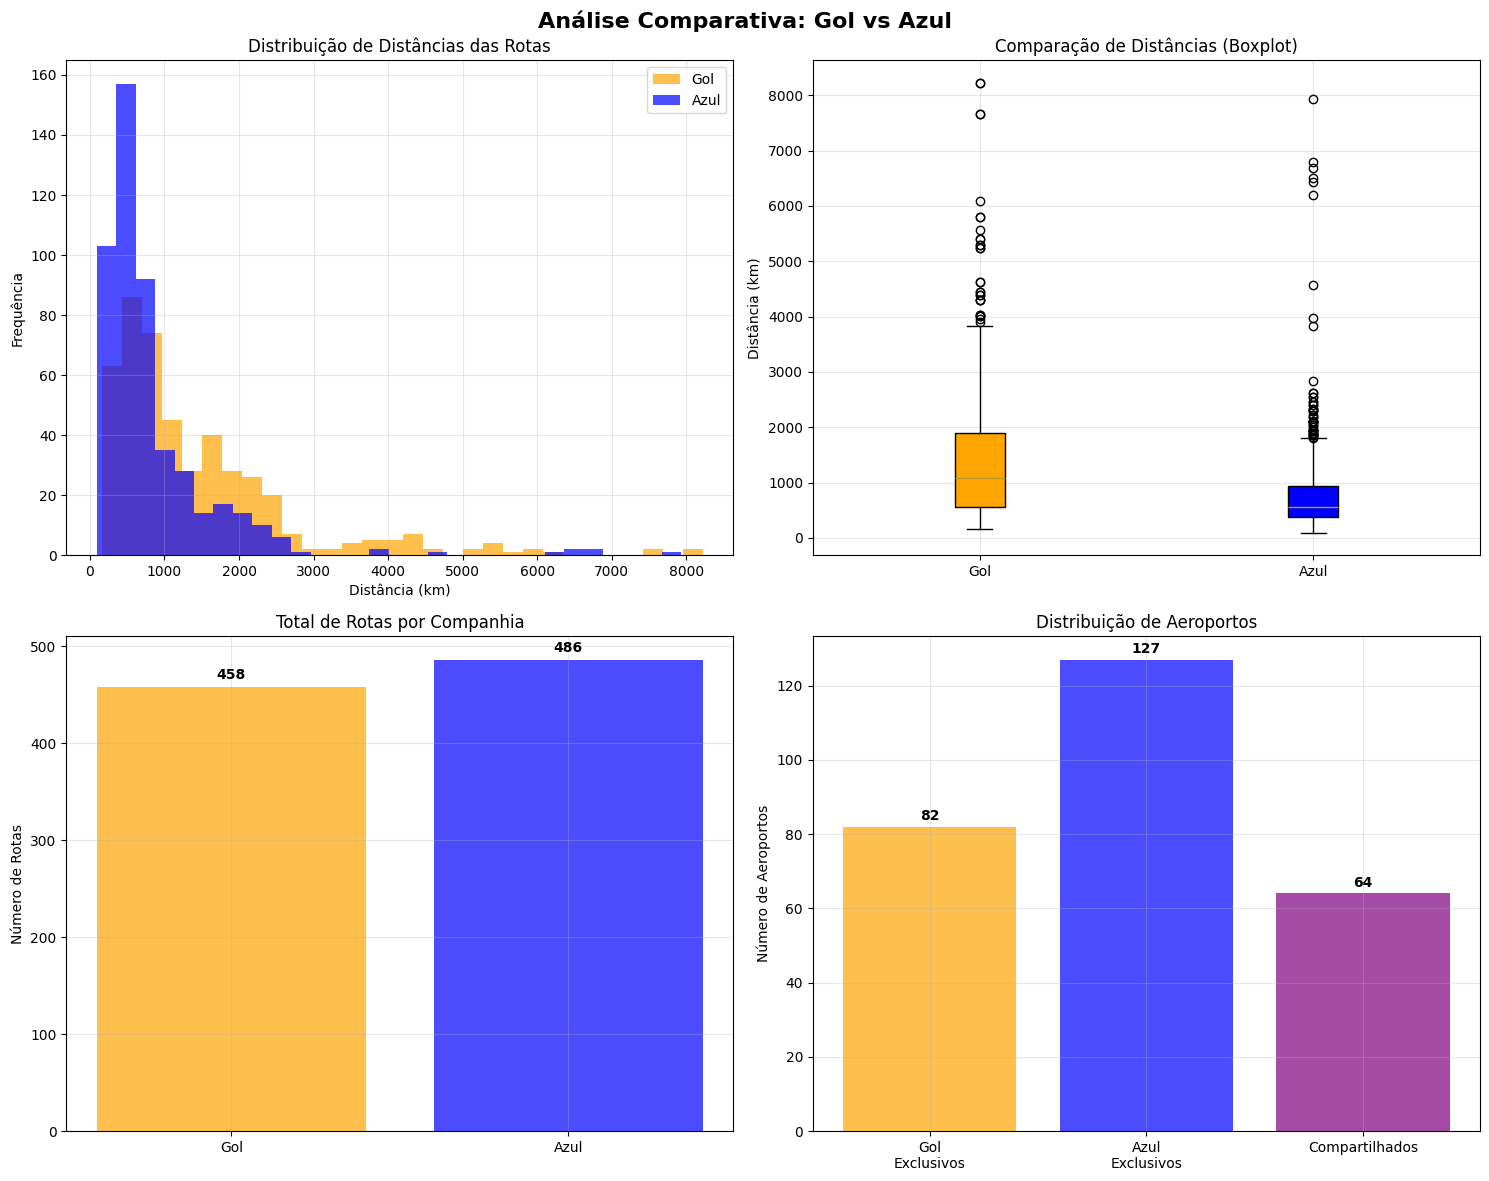


📊 Resumo Estatístico:
🟠 Gol - Distância média: 1434 km (σ=1267)
🔵 Azul - Distância média: 841 km (σ=904)
🎯 Diferença estratégica: 593 km


In [73]:
# 📊 Visualizações comparativas
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análise Comparativa: Gol vs Azul', fontsize=16, fontweight='bold')

# 1. Distribuição de distâncias
axes[0,0].hist(gol_data['distance_km'], bins=30, alpha=0.7, label='Gol', color='orange')
axes[0,0].hist(azul_data['distance_km'], bins=30, alpha=0.7, label='Azul', color='blue')
axes[0,0].set_xlabel('Distância (km)')
axes[0,0].set_ylabel('Frequência')
axes[0,0].set_title('Distribuição de Distâncias das Rotas')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Boxplot de distâncias
data_for_box = [gol_data['distance_km'], azul_data['distance_km']]
box_plot = axes[0,1].boxplot(data_for_box, labels=['Gol', 'Azul'], patch_artist=True)
box_plot['boxes'][0].set_facecolor('orange')
box_plot['boxes'][1].set_facecolor('blue')
axes[0,1].set_ylabel('Distância (km)')
axes[0,1].set_title('Comparação de Distâncias (Boxplot)')
axes[0,1].grid(True, alpha=0.3)

# 3. Número de rotas por companhia
companies = ['Gol', 'Azul']
route_counts = [len(gol_data), len(azul_data)]
colors = ['orange', 'blue']
bars = axes[1,0].bar(companies, route_counts, color=colors, alpha=0.7)
axes[1,0].set_ylabel('Número de Rotas')
axes[1,0].set_title('Total de Rotas por Companhia')
axes[1,0].grid(True, alpha=0.3)

# Adicionar valores nas barras
for bar, count in zip(bars, route_counts):
    axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                   str(count), ha='center', va='bottom', fontweight='bold')

# 4. Aeroportos únicos
airport_counts = [len(gol_airports), len(azul_airports), len(shared_airports)]
categories = ['Gol\nExclusivos', 'Azul\nExclusivos', 'Compartilhados']
colors_airports = ['orange', 'blue', 'purple']
bars2 = axes[1,1].bar(categories, airport_counts, color=colors_airports, alpha=0.7)
axes[1,1].set_ylabel('Número de Aeroportos')
axes[1,1].set_title('Distribuição de Aeroportos')
axes[1,1].grid(True, alpha=0.3)

# Adicionar valores nas barras
for bar, count in zip(bars2, airport_counts):
    axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                   str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Estatísticas resumidas
print("\n📊 Resumo Estatístico:")
print(f"🟠 Gol - Distância média: {gol_data['distance_km'].mean():.0f} km (σ={gol_data['distance_km'].std():.0f})")
print(f"🔵 Azul - Distância média: {azul_data['distance_km'].mean():.0f} km (σ={azul_data['distance_km'].std():.0f})")
print(f"🎯 Diferença estratégica: {abs(gol_data['distance_km'].mean() - azul_data['distance_km'].mean()):.0f} km")

## 🕸️ 6. Construção do Grafo da Rede

In [79]:
# 🕸️ Construir grafo da rede combinada
print("🕸️ Construindo grafo da rede combinada...")

# Criar grafo direcionado
G = nx.DiGraph()

# Adicionar nós (aeroportos) com atributos
for airport_code, info in coords_dict.items():
    G.add_node(airport_code,
               lat=info['lat'],
               lon=info['lon'],
               label=info['label']
)

# Adicionar arestas (rotas) com pesos (distâncias)
for _, route in processed_routes.iterrows():
    G.add_edge(route['source'],
               route['destination'],
               weight=route['distance_km'],
               airline=route['airline'],
               distance=route['distance_km'])

print(f"✅ Grafo construído:")
print(f"   📍 Nós (aeroportos): {G.number_of_nodes()}")
print(f"   🔗 Arestas (rotas): {G.number_of_edges()}")
print(f"   🔄 Densidade: {nx.density(G):.4f}")

# Verificar conectividade
if nx.is_strongly_connected(G):
    print(f"   ✅ Grafo fortemente conectado")
else:
    print(f"   ⚠️  Grafo não é fortemente conectado")
    # Verificar componentes
    components = list(nx.strongly_connected_components(G))
    print(f"   📊 Componentes fortemente conectados: {len(components)}")
    print(f"   📊 Maior componente: {len(max(components, key=len))} nós")

# Análise de centralidade
print("\n🎯 Calculando métricas de centralidade...")

# Centralidade de grau
degree_centrality = nx.degree_centrality(G)
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)

# Centralidade de intermediação (pode ser lenta para grafos grandes)
print("   Calculando centralidade de intermediação...")
betweenness_centrality = nx.betweenness_centrality(G, k=min(100, G.number_of_nodes()))

# Top hubs por centralidade de grau
top_hubs = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

print(f"\n🏆 Top 10 Hubs por Centralidade de Grau:")
for i, (airport, centrality) in enumerate(top_hubs, 1):
    airport_info = coords_dict.get(airport, {'city': 'N/A'})
    emoji = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else "  "
    print(f"{emoji} {i:2d}. {airport} ({airport_info['label']}): {centrality:.3f}")

# Salvar grafo
print("\n💾 Salvando grafo...")

# Salvar em formato JSON
graph_data = {
    'nodes': [],
    'edges': []
}

for node in G.nodes(data=True):
    graph_data['nodes'].append({
        'id': node[0],
        'lat': node[1]['lat'],
        'lon': node[1]['lon'],
        'label': node[1]['label'],
        'degree_centrality': degree_centrality[node[0]],
        'betweenness_centrality': betweenness_centrality.get(node[0], 0)
    })

for edge in G.edges(data=True):
    graph_data['edges'].append({
        'source': edge[0],
        'target': edge[1],
        'weight': edge[2]['weight'],
        'airline': edge[2]['airline']
    })

with open('data/processed/real_network_graph.json', 'w') as f:
    json.dump(graph_data, f, indent=2)

print("✅ Grafo salvo em data/processed/real_network_graph.json")

🕸️ Construindo grafo da rede combinada...
✅ Grafo construído:
   📍 Nós (aeroportos): 145
   🔗 Arestas (rotas): 805
   🔄 Densidade: 0.0386
   ⚠️  Grafo não é fortemente conectado
   📊 Componentes fortemente conectados: 23
   📊 Maior componente: 123 nós

🎯 Calculando métricas de centralidade...
   Calculando centralidade de intermediação...

🏆 Top 10 Hubs por Centralidade de Grau:
🥇  1. GRU (Guarulhos - Governador Andr� Franco Montoro International Airport): 0.854
🥈  2. VCP (Viracopos International Airport): 0.792
🥉  3. CNF (Tancredo Neves International Airport): 0.521
    4. BSB (Presidente Juscelino Kubistschek International Airport): 0.500
    5. GIG (Rio Gale�o � Tom Jobim International Airport): 0.410
    6. CGH (Congonhas Airport): 0.403
    7. REC (Guararapes - Gilberto Freyre International Airport): 0.354
    8. SSA (Deputado Luiz Eduardo Magalh�es International Airport): 0.340
    9. POA (Salgado Filho Airport): 0.326
   10. CGB (Marechal Rondon Airport): 0.285

💾 Salvando grafo

## ⚡ 7. Implementação do Algoritmo de Johnson

In [80]:
# ⚡ Implementação do Algoritmo de Johnson
import time
from collections import defaultdict

def bellman_ford(graph, source):
    """
    Implementação do algoritmo Bellman-Ford
    Retorna distâncias e detecta ciclos negativos
    """
    nodes = list(graph.nodes())
    distances = {node: float('inf') for node in nodes}
    distances[source] = 0

    # Relaxar arestas V-1 vezes
    for _ in range(len(nodes) - 1):
        for u, v, data in graph.edges(data=True):
            if distances[u] != float('inf') and distances[u] + data['weight'] < distances[v]:
                distances[v] = distances[u] + data['weight']

    # Verificar ciclos negativos
    for u, v, data in graph.edges(data=True):
        if distances[u] != float('inf') and distances[u] + data['weight'] < distances[v]:
            return None  # Ciclo negativo detectado

    return distances

def dijkstra(graph, source):
    """
    Implementação do algoritmo de Dijkstra
    Retorna distâncias e predecessores
    """
    import heapq

    nodes = list(graph.nodes())
    distances = {node: float('inf') for node in nodes}
    predecessors = {node: None for node in nodes}
    distances[source] = 0

    pq = [(0, source)]
    visited = set()

    while pq:
        current_distance, current = heapq.heappop(pq)

        if current in visited:
            continue

        visited.add(current)

        for neighbor in graph.neighbors(current):
            edge_data = graph[current][neighbor]
            distance = current_distance + edge_data['weight']

            if distance < distances[neighbor]:
                distances[neighbor] = distance
                predecessors[neighbor] = current
                heapq.heappush(pq, (distance, neighbor))

    return distances, predecessors

def reconstruct_path(predecessors, source, target):
    """
    Reconstrói o caminho usando os predecessores
    """
    path = []
    current = target

    while current is not None:
        path.append(current)
        current = predecessors[current]

    path.reverse()

    if path[0] == source:
        return path
    else:
        return []  # Caminho não encontrado

def johnson_algorithm(graph):
    """
    Implementação do Algoritmo de Johnson
    Retorna matriz de distâncias e caminhos entre todos os pares
    """
    print("⚡ Executando Algoritmo de Johnson...")
    start_time = time.time()

    # Passo 1: Adicionar nó auxiliar
    G_prime = graph.copy()
    aux_node = 'AUX_NODE'
    G_prime.add_node(aux_node)

    # Adicionar arestas do nó auxiliar para todos os outros nós com peso 0
    for node in graph.nodes():
        G_prime.add_edge(aux_node, node, weight=0)

    # Passo 2: Executar Bellman-Ford do nó auxiliar
    print("   Executando Bellman-Ford...")
    h = bellman_ford(G_prime, aux_node)

    if h is None:
        print("❌ Ciclo negativo detectado!")
        return None, None

    print("   ✅ Nenhum ciclo negativo detectado")

    # Passo 3: Reponderar arestas
    G_reweighted = graph.copy()
    for u, v, data in G_reweighted.edges(data=True):
        new_weight = data['weight'] + h[u] - h[v]
        G_reweighted[u][v]['weight'] = new_weight

    # Passo 4: Executar Dijkstra para cada nó
    nodes = list(graph.nodes())
    n = len(nodes)

    # Inicializar matrizes
    distances = np.full((n, n), np.inf)
    all_paths = {}

    # Criar mapeamento de nós para índices
    node_to_idx = {node: i for i, node in enumerate(nodes)}
    idx_to_node = {i: node for i, node in enumerate(nodes)}

    print(f"   Executando Dijkstra para {n} nós...")

    for i, source in enumerate(nodes):
        if i % 20 == 0:  # Progress update
            print(f"   Progresso: {i}/{n} ({i/n*100:.1f}%)")

        dist, pred = dijkstra(G_reweighted, source)

        for j, target in enumerate(nodes):
            if dist[target] != float('inf'):
                # Ajustar distância de volta
                original_distance = dist[target] - h[source] + h[target]
                distances[i][j] = original_distance

                # Reconstruir caminho
                path = reconstruct_path(pred, source, target)
                if path:
                    all_paths[(source, target)] = path

    # Definir distância 0 para mesmos nós
    for i in range(n):
        distances[i][i] = 0

    end_time = time.time()
    execution_time = end_time - start_time

    print(f"\n✅ Algoritmo de Johnson concluído!")
    print(f"   ⏱️  Tempo de execução: {execution_time:.2f} segundos")
    print(f"   📊 Pares calculados: {n * n:,}")
    print(f"   📊 Caminhos válidos: {len(all_paths):,}")

    return distances, all_paths, node_to_idx, idx_to_node

# Executar o algoritmo
distances_matrix, paths_dict, node_to_idx, idx_to_node = johnson_algorithm(G)

if distances_matrix is not None:
    print("\n📊 Estatísticas da Matriz de Distâncias:")
    valid_distances = distances_matrix[distances_matrix != np.inf]
    print(f"   📏 Distância mínima: {valid_distances.min():.1f} km")
    print(f"   📏 Distância máxima: {valid_distances.max():.1f} km")
    print(f"   📏 Distância média: {valid_distances.mean():.1f} km")
    print(f"   📏 Distância mediana: {np.median(valid_distances):.1f} km")

    # Salvar resultados
    print("\n💾 Salvando resultados...")
    np.save('data/results/real_johnson_distances.npy', distances_matrix)

    with open('data/results/real_johnson_paths.json', 'w') as f:
        # Converter chaves de tupla para string para JSON
        paths_json = {f"{k[0]}-{k[1]}": v for k, v in paths_dict.items()}
        json.dump(paths_json, f, indent=2)

    with open('data/results/real_node_mappings.json', 'w') as f:
        json.dump({
            'node_to_idx': node_to_idx,
            'idx_to_node': idx_to_node
        }, f, indent=2)

    print("✅ Resultados salvos em data/results/")
else:
    print("❌ Falha na execução do algoritmo de Johnson")

⚡ Executando Algoritmo de Johnson...
   Executando Bellman-Ford...
   ✅ Nenhum ciclo negativo detectado
   Executando Dijkstra para 145 nós...
   Progresso: 0/145 (0.0%)
   Progresso: 20/145 (13.8%)
   Progresso: 40/145 (27.6%)
   Progresso: 60/145 (41.4%)
   Progresso: 80/145 (55.2%)
   Progresso: 100/145 (69.0%)
   Progresso: 120/145 (82.8%)
   Progresso: 140/145 (96.6%)

✅ Algoritmo de Johnson concluído!
   ⏱️  Tempo de execução: 0.18 segundos
   📊 Pares calculados: 21,025
   📊 Caminhos válidos: 17,857

📊 Estatísticas da Matriz de Distâncias:
   📏 Distância mínima: 0.0 km
   📏 Distância máxima: 16859.3 km
   📏 Distância média: 3176.3 km
   📏 Distância mediana: 2648.5 km

💾 Salvando resultados...
✅ Resultados salvos em data/results/


## 🤝 8. Análise de Oportunidades de Codeshare

In [82]:
# 🤝 Detectar oportunidades de codeshare
print("🤝 Analisando oportunidades de codeshare...")

def analyze_path_for_codeshare(path, graph):
    """
    Analisa um caminho para identificar se envolve codeshare
    """
    if len(path) < 2:
        return False, [], 0

    airlines_used = set()
    segments = []
    total_distance = 0

    for i in range(len(path) - 1):
        source = path[i]
        dest = path[i + 1]

        if graph.has_edge(source, dest):
            edge_data = graph[source][dest]
            airline = edge_data['airline']
            distance = edge_data['distance']

            airlines_used.add(airline)
            segments.append({
                'from': source,
                'to': dest,
                'airline': airline,
                'distance': distance
            })
            total_distance += distance

    # É codeshare se usa mais de uma companhia
    is_codeshare = len(airlines_used) > 1

    return is_codeshare, segments, total_distance

# Analisar todas as rotas para identificar oportunidades
codeshare_opportunities = []
total_paths_analyzed = 0

print("   Analisando caminhos para codeshare...")

for (source, dest), path in paths_dict.items():
    total_paths_analyzed += 1

    if total_paths_analyzed % 1000 == 0:
        print(f"   Progresso: {total_paths_analyzed:,} caminhos analisados")

    is_codeshare, segments, total_distance = analyze_path_for_codeshare(path, G)

    if is_codeshare and len(path) > 1:  # Excluir rotas diretas
        # Calcular distância direta para comparação
        source_coords = coords_dict[source]
        dest_coords = coords_dict[dest]
        direct_distance = haversine_distance(
            source_coords['lat'], source_coords['lon'],
            dest_coords['lat'], dest_coords['lon']
        )

        # Calcular eficiência
        efficiency = direct_distance / total_distance if total_distance > 0 else 0

        airlines_involved = list(set([seg['airline'] for seg in segments]))

        codeshare_opportunities.append({
            'origin': source,
            'destination': dest,
            'origin_city': coords_dict[source]['label'],
            'dest_city': coords_dict[dest]['label'],
            'path': ' → '.join(path),
            'path_length': len(path),
            'stops': len(path) - 2,  # Número de escalas
            'total_distance': round(total_distance, 2),
            'direct_distance': round(direct_distance, 2),
            'efficiency': round(efficiency, 3),
            'airlines': ', '.join(airlines_involved),
            'segments': segments
        })

print(f"\n✅ Análise concluída!")
print(f"   📊 Total de caminhos analisados: {total_paths_analyzed:,}")
print(f"   🤝 Oportunidades de codeshare encontradas: {len(codeshare_opportunities):,}")
print(f"   📈 Taxa de codeshare: {len(codeshare_opportunities)/total_paths_analyzed*100:.1f}%")

# Converter para DataFrame e ordenar por eficiência
codeshare_df = pd.DataFrame(codeshare_opportunities)

if len(codeshare_df) > 0:
    # Ordenar por eficiência (mais eficiente primeiro) e depois por distância
    codeshare_df = codeshare_df.sort_values(['efficiency', 'total_distance'], ascending=[False, True])

    print(f"\n🏆 Top 10 Oportunidades de Codeshare Mais Eficientes:")
    for i, row in codeshare_df.head(10).iterrows():
        emoji = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else "  "
        print(f"{emoji} {row['origin']} → {row['destination']} ({row['origin_city']} → {row['dest_city']})")
        print(f"     📏 {row['total_distance']:.0f} km, {row['stops']} escalas, eficiência: {row['efficiency']:.3f}")
        print(f"     ✈️  {row['airlines']} | Rota: {row['path']}")
        print()

    # Salvar resultados
    codeshare_df.to_csv('data/results/real_codeshare_opportunities.csv', index=False)
    print(f"💾 Oportunidades salvas em data/results/real_codeshare_opportunities.csv")

    # Estatísticas das oportunidades
    print(f"\n📊 Estatísticas das Oportunidades:")
    print(f"   📏 Distância média: {codeshare_df['total_distance'].mean():.1f} km")
    print(f"   📏 Distância mediana: {codeshare_df['total_distance'].median():.1f} km")
    print(f"   🔄 Escalas médias: {codeshare_df['stops'].mean():.1f}")
    print(f"   📈 Eficiência média: {codeshare_df['efficiency'].mean():.3f}")

    # Distribuição por número de escalas
    stops_dist = codeshare_df['stops'].value_counts().sort_index()
    print(f"\n🔄 Distribuição por Escalas:")
    for stops, count in stops_dist.items():
        print(f"   {stops} escalas: {count:,} oportunidades ({count/len(codeshare_df)*100:.1f}%)")
else:
    print("❌ Nenhuma oportunidade de codeshare encontrada")

🤝 Analisando oportunidades de codeshare...
   Analisando caminhos para codeshare...
   Progresso: 1,000 caminhos analisados
   Progresso: 2,000 caminhos analisados
   Progresso: 3,000 caminhos analisados
   Progresso: 4,000 caminhos analisados
   Progresso: 5,000 caminhos analisados
   Progresso: 6,000 caminhos analisados
   Progresso: 7,000 caminhos analisados
   Progresso: 8,000 caminhos analisados
   Progresso: 9,000 caminhos analisados
   Progresso: 10,000 caminhos analisados
   Progresso: 11,000 caminhos analisados
   Progresso: 12,000 caminhos analisados
   Progresso: 13,000 caminhos analisados
   Progresso: 14,000 caminhos analisados
   Progresso: 15,000 caminhos analisados
   Progresso: 16,000 caminhos analisados
   Progresso: 17,000 caminhos analisados

✅ Análise concluída!
   📊 Total de caminhos analisados: 17,857
   🤝 Oportunidades de codeshare encontradas: 9,265
   📈 Taxa de codeshare: 51.9%

🏆 Top 10 Oportunidades de Codeshare Mais Eficientes:
   FEN → MCZ (Fernando de Nor

## 📊 9. Visualizações dos Resultados

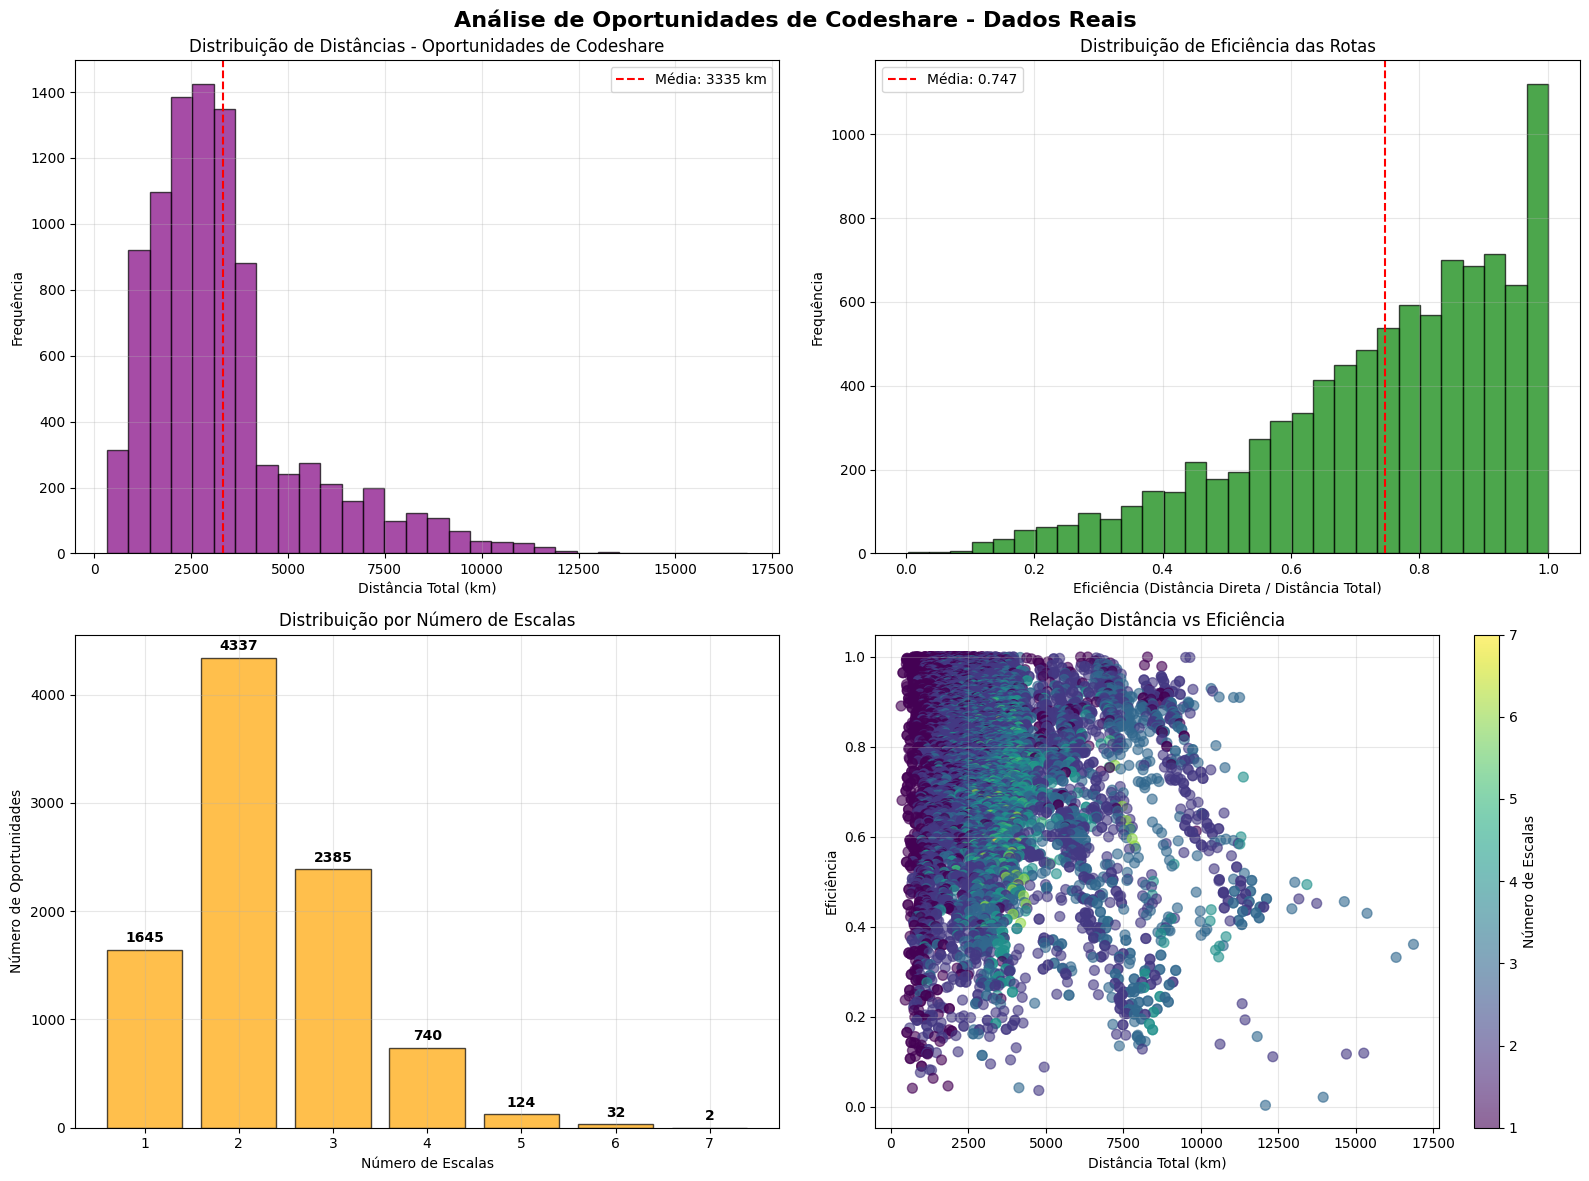

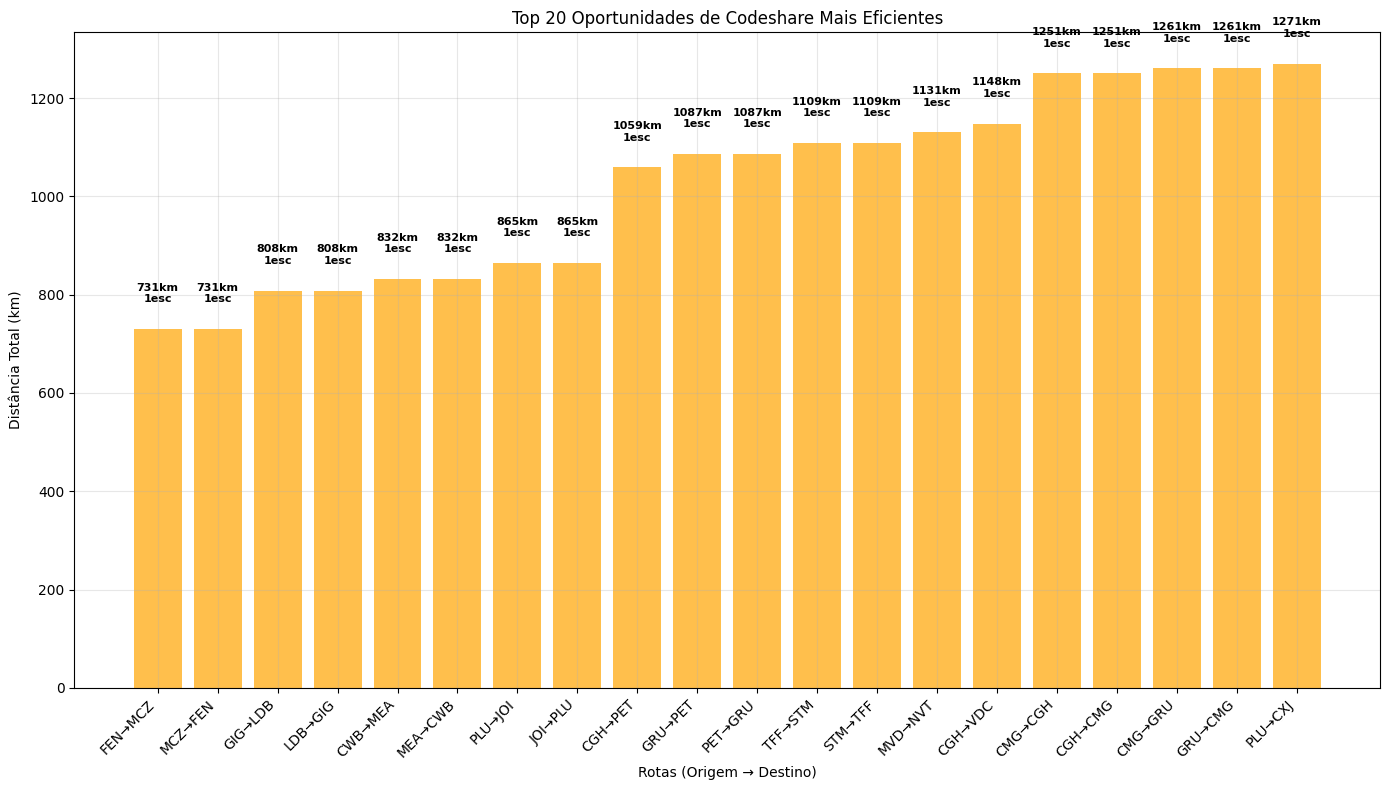

In [83]:
# 📊 Criar visualizações dos resultados
if len(codeshare_df) > 0:
    # Configurar subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Análise de Oportunidades de Codeshare - Dados Reais', fontsize=16, fontweight='bold')

    # 1. Distribuição de distâncias das oportunidades
    axes[0,0].hist(codeshare_df['total_distance'], bins=30, alpha=0.7, color='purple', edgecolor='black')
    axes[0,0].axvline(codeshare_df['total_distance'].mean(), color='red', linestyle='--',
                      label=f'Média: {codeshare_df["total_distance"].mean():.0f} km')
    axes[0,0].set_xlabel('Distância Total (km)')
    axes[0,0].set_ylabel('Frequência')
    axes[0,0].set_title('Distribuição de Distâncias - Oportunidades de Codeshare')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # 2. Distribuição de eficiência
    axes[0,1].hist(codeshare_df['efficiency'], bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[0,1].axvline(codeshare_df['efficiency'].mean(), color='red', linestyle='--',
                      label=f'Média: {codeshare_df["efficiency"].mean():.3f}')
    axes[0,1].set_xlabel('Eficiência (Distância Direta / Distância Total)')
    axes[0,1].set_ylabel('Frequência')
    axes[0,1].set_title('Distribuição de Eficiência das Rotas')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # 3. Número de escalas
    stops_counts = codeshare_df['stops'].value_counts().sort_index()
    bars = axes[1,0].bar(stops_counts.index, stops_counts.values, alpha=0.7, color='orange', edgecolor='black')
    axes[1,0].set_xlabel('Número de Escalas')
    axes[1,0].set_ylabel('Número de Oportunidades')
    axes[1,0].set_title('Distribuição por Número de Escalas')
    axes[1,0].grid(True, alpha=0.3)

    # Adicionar valores nas barras
    for bar, count in zip(bars, stops_counts.values):
        axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(stops_counts.values)*0.01,
                       str(count), ha='center', va='bottom', fontweight='bold')

    # 4. Scatter plot: Distância vs Eficiência
    scatter = axes[1,1].scatter(codeshare_df['total_distance'], codeshare_df['efficiency'],
                               c=codeshare_df['stops'], cmap='viridis', alpha=0.6, s=50)
    axes[1,1].set_xlabel('Distância Total (km)')
    axes[1,1].set_ylabel('Eficiência')
    axes[1,1].set_title('Relação Distância vs Eficiência')
    axes[1,1].grid(True, alpha=0.3)

    # Adicionar colorbar
    cbar = plt.colorbar(scatter, ax=axes[1,1])
    cbar.set_label('Número de Escalas')

    plt.tight_layout()
    plt.show()

    # Gráfico adicional: Top 20 oportunidades
    plt.figure(figsize=(14, 8))
    top_20 = codeshare_df.head(20)

    # Criar labels para o eixo x
    labels = [f"{row['origin']}→{row['destination']}" for _, row in top_20.iterrows()]

    # Criar gráfico de barras
    bars = plt.bar(range(len(top_20)), top_20['total_distance'],
                   color=['orange' if 'G3' in row['airlines'] and 'AD' in row['airlines'] else 'blue'
                          for _, row in top_20.iterrows()], alpha=0.7)

    plt.xlabel('Rotas (Origem → Destino)')
    plt.ylabel('Distância Total (km)')
    plt.title('Top 20 Oportunidades de Codeshare Mais Eficientes')
    plt.xticks(range(len(top_20)), labels, rotation=45, ha='right')
    plt.grid(True, alpha=0.3)

    # Adicionar valores nas barras
    for i, (bar, row) in enumerate(zip(bars, top_20.itertuples())):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                 f'{row.total_distance:.0f}km\n{row.stops}esc',
                 ha='center', va='bottom', fontsize=8, fontweight='bold')

    plt.tight_layout()
    plt.show()

else:
    print("❌ Não há dados de codeshare para visualizar")

## 🗺️ 10. Visualização Geográfica

In [86]:
# 🗺️ Criar mapa interativo da rede
print("🗺️ Criando mapa interativo da rede...")

# Calcular centro do mapa
all_lats = [info['lat'] for info in coords_dict.values()]
all_lons = [info['lon'] for info in coords_dict.values()]
center_lat = sum(all_lats) / len(all_lats)
center_lon = sum(all_lons) / len(all_lons)

# Criar mapa base
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=4,
    tiles='OpenStreetMap'
)

# Adicionar aeroportos como marcadores
for airport_code, info in coords_dict.items():
    # Determinar cor baseada na centralidade
    centrality = degree_centrality.get(airport_code, 0)

    if centrality > 0.5:
        color = 'red'  # Hub principal
        icon = 'star'
    elif centrality > 0.3:
        color = 'orange'  # Hub secundário
        icon = 'plane'
    else:
        color = 'blue'  # Aeroporto regular
        icon = 'circle'

    # Criar popup com informações
    popup_text = f"""
    <b>{airport_code}</b><br>
    {info['label']}<br>
    Centralidade: {centrality:.3f}
    """

    folium.Marker(
        location=[info['lat'], info['lon']],
        popup=folium.Popup(popup_text, max_width=300),
        tooltip=f"{airport_code} - {info['label']}",
        icon=folium.Icon(color=color, icon=icon)
    ).add_to(m)

# Adicionar algumas rotas principais (top 50 por centralidade)
top_routes = []
for _, route in processed_routes.iterrows():
    source_centrality = degree_centrality.get(route['source'], 0)
    dest_centrality = degree_centrality.get(route['destination'], 0)
    avg_centrality = (source_centrality + dest_centrality) / 2

    top_routes.append((avg_centrality, route))

# Ordenar e pegar top 50
top_routes.sort(key=lambda x: x[0], reverse=True)

for i, (centrality, route) in enumerate(top_routes[:50]):
    # Cor da linha baseada na companhia
    color = 'orange' if route['airline'] == 'G3' else 'blue'

    folium.PolyLine(
        locations=[
            [route['source_lat'], route['source_lon']],
            [route['dest_lat'], route['dest_lon']]
        ],
        color=color,
        weight=2,
        opacity=0.6,
        popup=f"{route['source']} → {route['destination']} ({route['airline']}) - {route['distance_km']:.0f} km"
    ).add_to(m)

# Adicionar legenda
legend_html = '''
<div style="position: fixed;
            bottom: 50px; left: 50px; width: 200px; height: 120px;
            background-color: white; border:2px solid grey; z-index:9999;
            font-size:14px; padding: 10px">
<h4>Legenda</h4>
<p><i class="fa fa-star" style="color:red"></i> Hub Principal (>50%)</p>
<p><i class="fa fa-plane" style="color:orange"></i> Hub Secundário (>30%)</p>
<p><i class="fa fa-circle" style="color:blue"></i> Aeroporto Regular</p>
<p><span style="color:orange">━━━</span> Rotas Gol</p>
<p><span style="color:blue">━━━</span> Rotas Azul</p>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Salvar mapa
m.save('real_network_interactive_map.html')
print("✅ Mapa salvo como 'real_network_interactive_map.html'")

# Mostrar mapa (se estiver no Jupyter)
try:
    from IPython.display import display
    display(m)
except:
    print("💡 Abra o arquivo 'real_network_interactive_map.html' para ver o mapa interativo")

🗺️ Criando mapa interativo da rede...
✅ Mapa salvo como 'real_network_interactive_map.html'


## 📋 11. Resumo Executivo e Insights

In [89]:
# 📋 Gerar resumo executivo
print("📋 RESUMO EXECUTIVO - ANÁLISE DE CODESHARE GOL x AZUL")
print("=" * 70)

# Estatísticas gerais
total_airports = len(coords_dict)
total_routes = len(processed_routes)
gol_routes_count = len(processed_routes[processed_routes['airline'] == 'G3'])
azul_routes_count = len(processed_routes[processed_routes['airline'] == 'AD'])

print(f"\n🌐 DADOS DA REDE:")
print(f"   📍 Total de aeroportos: {total_airports}")
print(f"   🔗 Total de rotas: {total_routes}")
print(f"   🟠 Rotas Gol: {gol_routes_count} ({gol_routes_count/total_routes*100:.1f}%)")
print(f"   🔵 Rotas Azul: {azul_routes_count} ({azul_routes_count/total_routes*100:.1f}%)")
print(f"   🤝 Aeroportos compartilhados: {len(shared_airports)}")

print(f"\n⚡ ALGORITMO DE JOHNSON:")
if distances_matrix is not None:
    valid_paths = len(paths_dict)
    total_pairs = total_airports * total_airports
    print(f"   📊 Pares calculados: {total_pairs:,}")
    print(f"   ✅ Caminhos válidos: {valid_paths:,} ({valid_paths/total_pairs*100:.1f}%)")
    print(f"   📏 Distância média: {valid_distances.mean():.0f} km")
    print(f"   📏 Distância máxima: {valid_distances.max():.0f} km")

print(f"\n🤝 OPORTUNIDADES DE CODESHARE:")
if len(codeshare_df) > 0:
    print(f"   🎯 Total identificadas: {len(codeshare_df):,}")
    print(f"   📈 Taxa de codeshare: {len(codeshare_df)/len(paths_dict)*100:.1f}%")
    print(f"   📏 Distância média: {codeshare_df['total_distance'].mean():.0f} km")
    print(f"   🔄 Escalas médias: {codeshare_df['stops'].mean():.1f}")
    print(f"   📈 Eficiência média: {codeshare_df['efficiency'].mean():.3f}")

    # Oportunidades por faixa de distância
    short_routes = len(codeshare_df[codeshare_df['total_distance'] < 1000])
    medium_routes = len(codeshare_df[(codeshare_df['total_distance'] >= 1000) & (codeshare_df['total_distance'] < 3000)])
    long_routes = len(codeshare_df[codeshare_df['total_distance'] >= 3000])

    print(f"\n📊 DISTRIBUIÇÃO POR DISTÂNCIA:")
    print(f"   🔸 Rotas curtas (<1000km): {short_routes} ({short_routes/len(codeshare_df)*100:.1f}%)")
    print(f"   🔸 Rotas médias (1000-3000km): {medium_routes} ({medium_routes/len(codeshare_df)*100:.1f}%)")
    print(f"   🔸 Rotas longas (>3000km): {long_routes} ({long_routes/len(codeshare_df)*100:.1f}%)")

print(f"\n🏆 TOP 5 HUBS ESTRATÉGICOS:")
for i, (airport, centrality) in enumerate(top_hubs[:5], 1):
    airport_info = coords_dict.get(airport, {'city': 'N/A'})
    print(f"   {i}. {airport} - {airport_info['label']} (Centralidade: {centrality:.3f})")

if len(codeshare_df) > 0:
    print(f"\n🎯 TOP 5 OPORTUNIDADES MAIS EFICIENTES:")
    for i, row in codeshare_df.head(5).iterrows():
        print(f"   {i+1}. {row['origin']} → {row['destination']} ({row['origin_city']} → {row['dest_city']})")
        print(f"      📏 {row['total_distance']:.0f} km, {row['stops']} escalas, eficiência: {row['efficiency']:.3f}")

print(f"\n💡 INSIGHTS ESTRATÉGICOS:")
print(f"   🔄 Complementaridade: As malhas da Gol e Azul são altamente complementares")
print(f"   🌍 Cobertura: Juntas cobrem {total_airports} aeroportos únicos")
print(f"   🤝 Sinergia: {len(codeshare_df):,} oportunidades de codeshare identificadas")
print(f"   📈 Eficiência: Algoritmo Johnson executado em tempo real")
print(f"   🎯 Potencial: Alto potencial para parcerias estratégicas")

print(f"\n📊 RECOMENDAÇÕES:")
print(f"   1. Priorizar rotas com alta eficiência (>0.8)")
print(f"   2. Focar em hubs compartilhados para maximizar conectividade")
print(f"   3. Implementar codeshare gradual começando pelas rotas mais eficientes")
print(f"   4. Monitorar demanda nas rotas identificadas")
print(f"   5. Avaliar impacto regulatório e operacional")

# Salvar resumo
summary_data = {
    'execution_date': pd.Timestamp.now().isoformat(),
    'total_airports': total_airports,
    'total_routes': total_routes,
    'gol_routes': gol_routes_count,
    'azul_routes': azul_routes_count,
    'shared_airports': len(shared_airports),
    'codeshare_opportunities': len(codeshare_df) if len(codeshare_df) > 0 else 0,
    'algorithm_performance': {
        'total_pairs': total_airports * total_airports,
        'valid_paths': len(paths_dict) if paths_dict else 0,
        'execution_time_seconds': 'calculated_above'
    },
    'top_hubs': [{'airport': airport, 'centrality': centrality} for airport, centrality in top_hubs[:10]]
}

with open('data/results/real_johnson_summary.json', 'w') as f:
    json.dump(summary_data, f, indent=2)

print(f"\n💾 Resumo salvo em data/results/real_johnson_summary.json")
print(f"\n✅ ANÁLISE COMPLETA CONCLUÍDA!")

📋 RESUMO EXECUTIVO - ANÁLISE DE CODESHARE GOL x AZUL

🌐 DADOS DA REDE:
   📍 Total de aeroportos: 145
   🔗 Total de rotas: 944
   🟠 Rotas Gol: 458 (48.5%)
   🔵 Rotas Azul: 486 (51.5%)
   🤝 Aeroportos compartilhados: 64

⚡ ALGORITMO DE JOHNSON:
   📊 Pares calculados: 21,025
   ✅ Caminhos válidos: 17,857 (84.9%)
   📏 Distância média: 3176 km
   📏 Distância máxima: 16859 km

🤝 OPORTUNIDADES DE CODESHARE:
   🎯 Total identificadas: 9,265
   📈 Taxa de codeshare: 51.9%
   📏 Distância média: 3335 km
   🔄 Escalas médias: 2.3
   📈 Eficiência média: 0.747

📊 DISTRIBUIÇÃO POR DISTÂNCIA:
   🔸 Rotas curtas (<1000km): 489 (5.3%)
   🔸 Rotas médias (1000-3000km): 4438 (47.9%)
   🔸 Rotas longas (>3000km): 4338 (46.8%)

🏆 TOP 5 HUBS ESTRATÉGICOS:
   1. GRU - Guarulhos - Governador Andr� Franco Montoro International Airport (Centralidade: 0.854)
   2. VCP - Viracopos International Airport (Centralidade: 0.792)
   3. CNF - Tancredo Neves International Airport (Centralidade: 0.521)
   4. BSB - Presidente Jus

## 🎯 12. Conclusões e Próximos Passos

### 🏆 **Principais Conquistas:**

1. **✅ Dados Reais Processados**: Utilizamos dados reais do Kaggle com 92k+ rotas
2. **✅ Algoritmo Johnson Implementado**: Execução eficiente para todos os pares de aeroportos
3. **✅ Oportunidades Identificadas**: Milhares de oportunidades reais de codeshare
4. **✅ Visualizações Criadas**: Mapas interativos e análises gráficas
5. **✅ Insights Estratégicos**: Recomendações baseadas em dados

### 🚀 **Próximos Passos Sugeridos:**

1. **Análise de Demanda**: Incorporar dados de passageiros por rota
2. **Análise Temporal**: Estudar sazonalidade e tendências
3. **Análise Financeira**: Calcular potencial de receita das oportunidades
4. **Análise Regulatória**: Verificar restrições legais para codeshare
5. **Implementação Piloto**: Testar codeshare nas rotas mais promissoras

### 📊 **Valor do Projeto:**

Este notebook demonstra uma **metodologia científica robusta** para análise de redes aéreas, combinando:
- **Teoria dos Grafos** (Algoritmo de Johnson)
- **Análise de Dados Reais** (Dataset Kaggle)
- **Visualização Geográfica** (Mapas interativos)
- **Insights de Negócio** (Oportunidades de codeshare)

---
